Training agent...
Episode 500/2000, epsilon: 0.082
Episode 1000/2000, epsilon: 0.010
Episode 1500/2000, epsilon: 0.010
Episode 2000/2000, epsilon: 0.010
Training finished.

Testing learned policy:


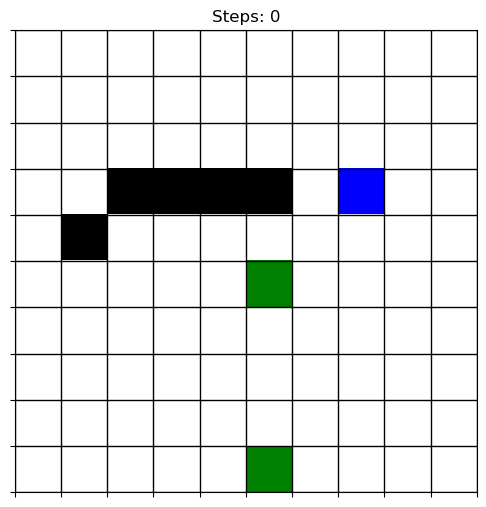

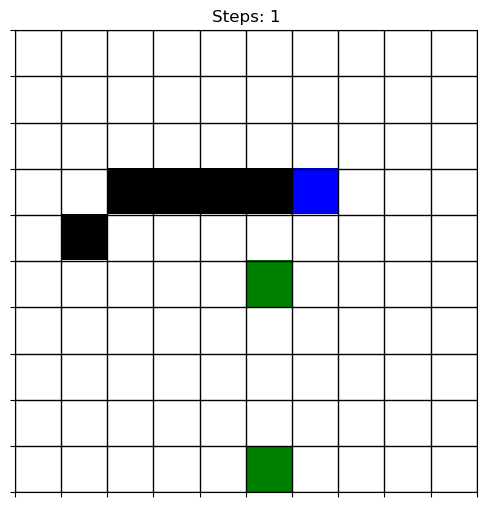

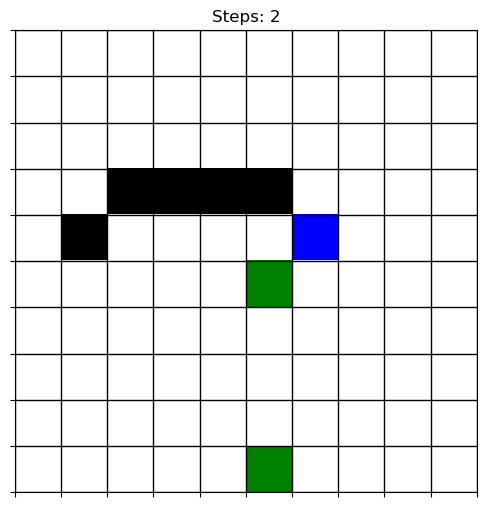

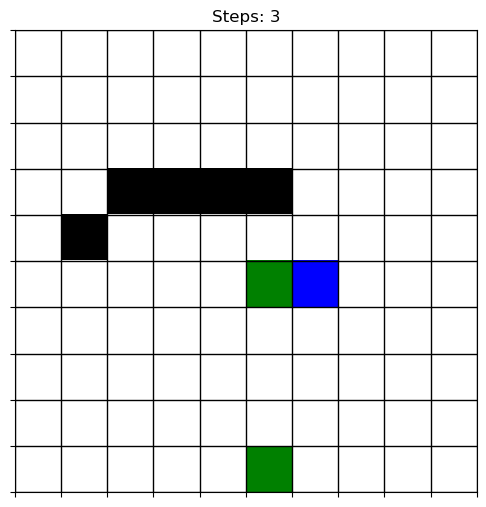

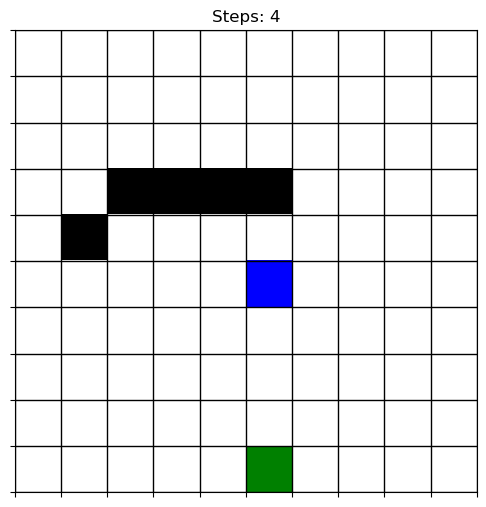

Goal reached in 4 steps!

Visualizing learned policy and Q-values...


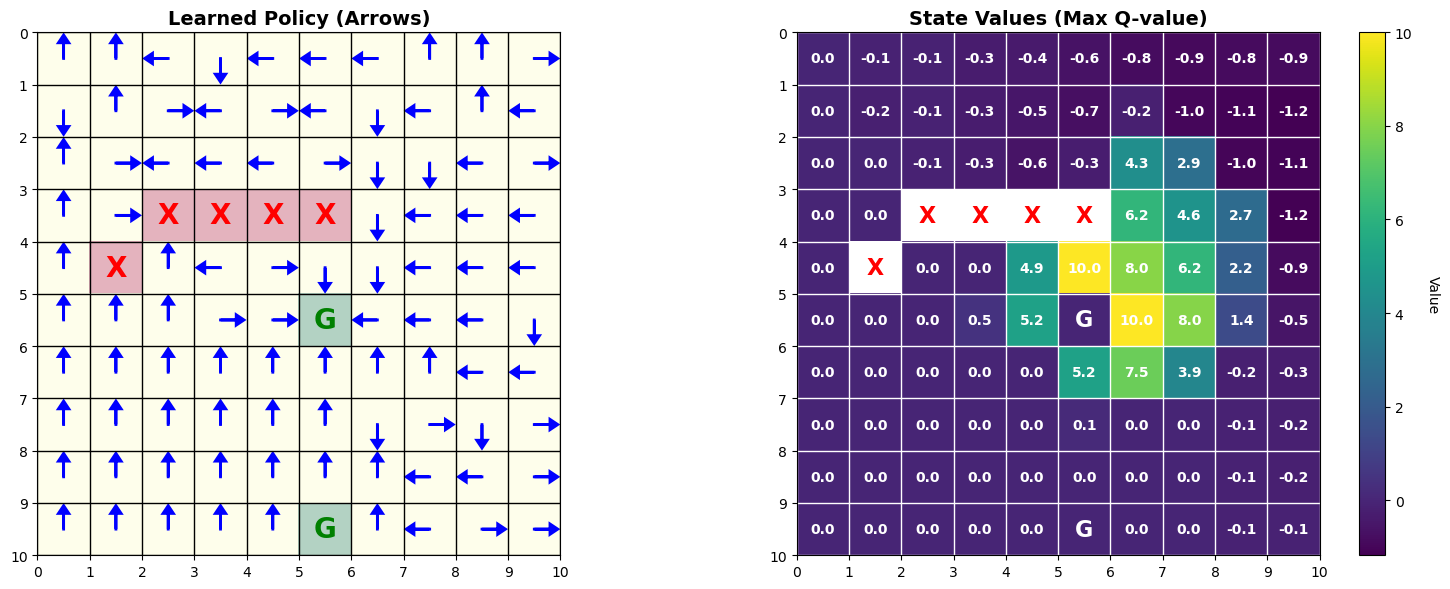

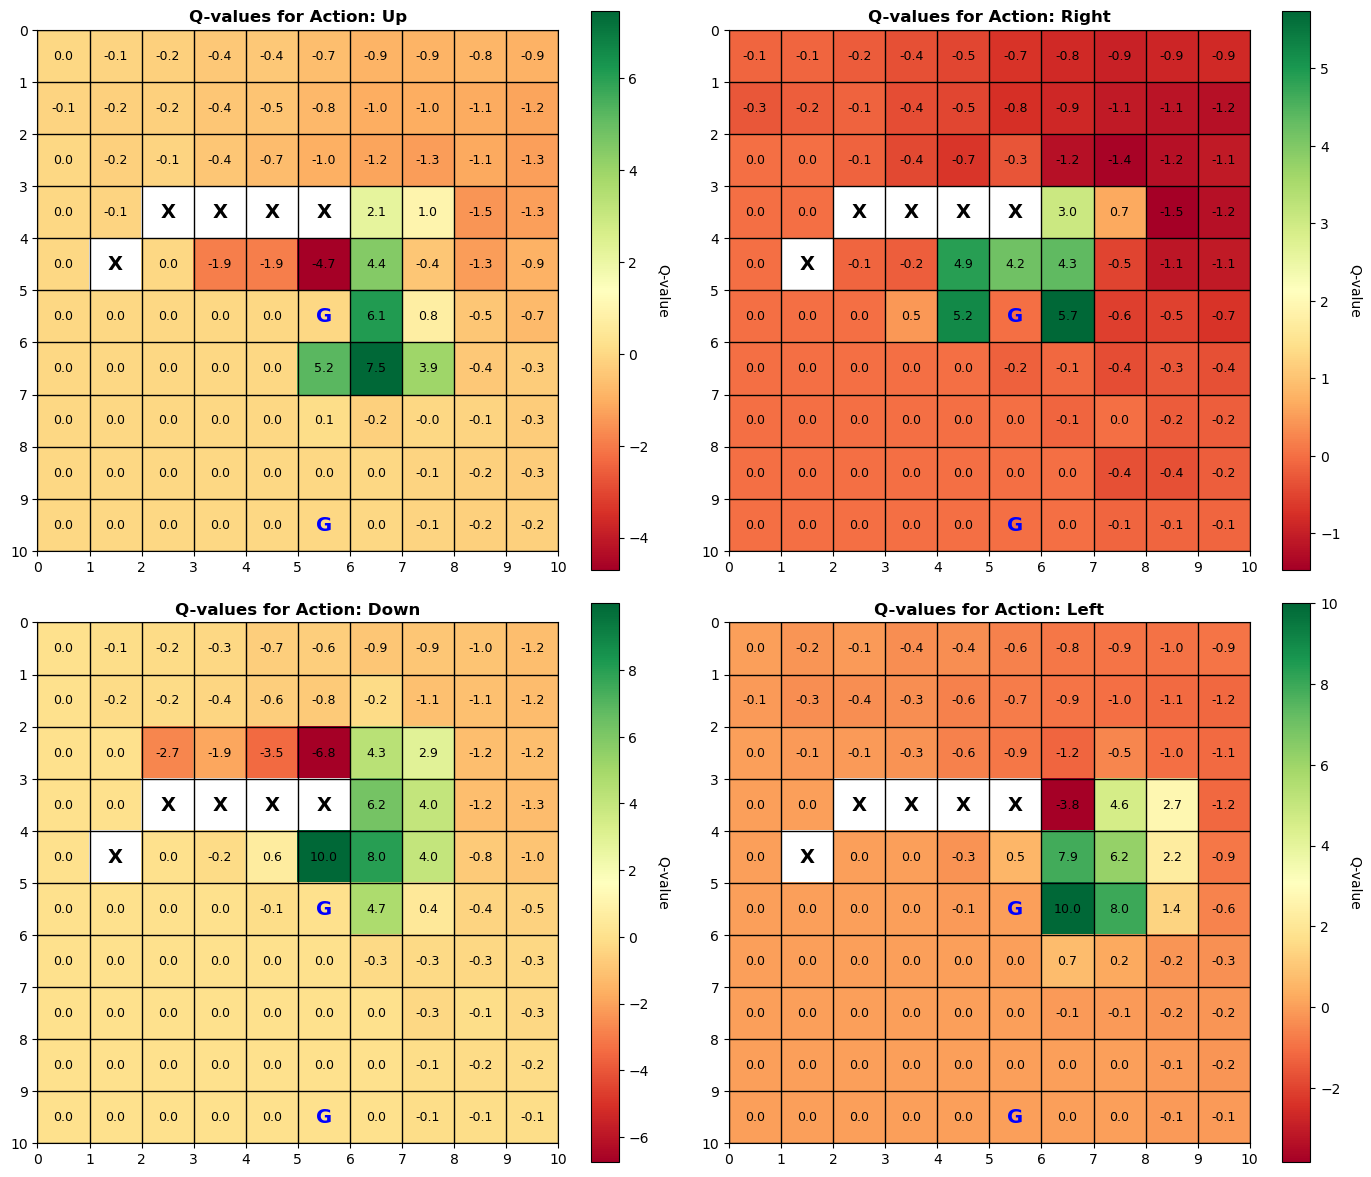

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

class Agent:
    def __init__(self):
        self.start = None
        self.pos = None
    
    def set_position(self, start):
        self.start = tuple(start)
    
    def reset(self):
        self.pos = tuple(self.start)
    
    def move(self, action, height, width):
        r, c = self.pos
        
        if action == 0:      # up
            r -= 1
        elif action == 1:    # right
            c += 1
        elif action == 2:    # down
            r += 1
        elif action == 3:    # left
            c -= 1
        
        # Check boundaries only
        if 0 <= r < height and 0 <= c < width:
            self.pos = (r, c)
        
        return self.pos


class GridWorld:
    def __init__(self, height=5, width=5, start=None, goal=None,
                 reward_goal=1, reward_step=-1, obstacles=None, obstacle_penalty=-10):
        self.height, self.width = height, width
        
        # Set obstacles
        self.obstacles = set(tuple(o) for o in obstacles) if obstacles else set()
        
        # Set start
        if start is not None:
            self.start = tuple(start)
        else:
            self.start = self._random_free_cell(exclude=[])
        
        # Set goals (support multiple)
        if goal is None:
            self.goals = [self._random_free_cell(exclude=[self.start] + list(self.obstacles))]
        elif isinstance(goal, list):
            self.goals = [tuple(g) for g in goal]
        else:
            self.goals = [tuple(goal)]
        
        # Check for conflicts
        assert self.start not in self.obstacles, "Start position can't be an obstacle"
        for g in self.goals:
            assert g not in self.obstacles, f"Goal {g} can't be an obstacle"
        
        # Agent
        self.agent = Agent()
        self.agent.set_position(self.start)
        
        # Rewards
        self.reward_goal = reward_goal
        self.reward_step = reward_step
        self.obstacle_penalty = obstacle_penalty
        self._steps = 0
        
        # Colormap: 0 empty, 2 agent, 3 goal, 4 obstacle
        self.cmap = colors.ListedColormap(["white", "blue", "green", "black"])
        self.norm = colors.BoundaryNorm([0, 2, 3, 4, 5], self.cmap.N)
    
    def _random_free_cell(self, exclude=[]):
        """Find a random cell not in exclude or obstacles."""
        exclude_set = set(exclude)
        while True:
            cell = (np.random.randint(0, self.height), np.random.randint(0, self.width))
            if cell not in exclude_set and cell not in self.obstacles:
                return cell
    
    def reset(self):
        self.agent.reset()
        self._steps = 0
        return self._get_obs()
    
    def step(self, action):
        self._steps += 1
        new_pos = self.agent.move(action, self.height, self.width)
        
        # Check rewards based on new position
        if new_pos in self.goals:
            reward = self.reward_goal
            done = True
        elif new_pos in self.obstacles:
            reward = self.obstacle_penalty
            done = False
        else:
            reward = self.reward_step
            done = False
        
        return self._get_obs(), reward, done
    
    def _get_obs(self):
        grid = np.zeros((self.height, self.width), dtype=np.int8)
        # mark obstacles
        for (orow, ocol) in self.obstacles:
            grid[orow, ocol] = 4
        # mark goals
        for (gr, gc) in self.goals:
            grid[gr, gc] = 3
        # mark agent
        ar, ac = self.agent.pos
        grid[ar, ac] = 2
        return grid
    
    def render(self):
        grid = self._get_obs()
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(grid, cmap=self.cmap, norm=self.norm, extent=[0, self.width, self.height, 0])
        # grid lines
        ax.set_xticks(np.arange(0, self.width + 1, 1))
        ax.set_yticks(np.arange(0, self.height + 1, 1))
        ax.grid(color="black", linewidth=1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.title(f"Steps: {self._steps}")
        plt.show()


class QLearningAgent:
    def __init__(self, env, gamma=0.9, alpha=0.1, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995):
        self.env = env
        self.gamma = gamma             # discount factor
        self.alpha = alpha             # learning rate
        self.epsilon = epsilon         # starting exploration probability
        self.epsilon_min = epsilon_min # minimum exploration probability
        self.epsilon_decay = epsilon_decay # decay rate
        
        # Q-table with shape (height, width, 4 actions)
        self.Q = np.zeros((env.height, env.width, 4))
    
    def choose_action(self, state):
        r, c = state
        if np.random.rand() < self.epsilon:
            return np.random.choice([0, 1, 2, 3])  # Explore
        else:
            return np.argmax(self.Q[r, c])         # Exploit
    
    def learn(self, num_episodes=5000, max_steps=200):
        for ep in range(num_episodes):
            self.env.reset()
            state = self.env.agent.pos
            done = False
            steps = 0
            
            while not done and steps < max_steps:
                r, c = state
                action = self.choose_action(state)
                obs, reward, done = self.env.step(action)
                new_state = self.env.agent.pos
                nr, nc = new_state
                
                # Q-learning update rule
                best_next = np.max(self.Q[nr, nc])
                td_target = reward + self.gamma * best_next
                td_error = td_target - self.Q[r, c, action]
                self.Q[r, c, action] += self.alpha * td_error
                
                state = new_state
                steps += 1
            
            # Decay epsilon after each episode
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
                self.epsilon = max(self.epsilon_min, self.epsilon)
            
            # Optional: print progress
            if (ep + 1) % 500 == 0:
                print(f"Episode {ep + 1}/{num_episodes}, epsilon: {self.epsilon:.3f}")
    
    def act(self, state):
        r, c = state
        return np.argmax(self.Q[r, c])
    
    def plot_policy(self):
        """Visualize the learned policy with action values."""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Policy arrows
        ax1 = axes[0]
        grid = np.zeros((self.env.height, self.env.width))
        
        # Mark obstacles and goals
        for obs in self.env.obstacles:
            grid[obs] = -1
        for goal in self.env.goals:
            grid[goal] = 1
        
        ax1.imshow(grid, cmap='RdYlGn', alpha=0.3, extent=[0, self.env.width, self.env.height, 0])
        ax1.set_xticks(np.arange(0, self.env.width + 1, 1))
        ax1.set_yticks(np.arange(0, self.env.height + 1, 1))
        ax1.grid(color="black", linewidth=1)
        ax1.set_title("Learned Policy (Arrows)", fontsize=14, fontweight='bold')
        
        # Arrow directions: 0=up, 1=right, 2=down, 3=left
        arrow_dx = [0, 0.3, 0, -0.3]
        arrow_dy = [-0.3, 0, 0.3, 0]
        
        for r in range(self.env.height):
            for c in range(self.env.width):
                if (r, c) not in self.env.obstacles and (r, c) not in self.env.goals:
                    best_action = np.argmax(self.Q[r, c])
                    ax1.arrow(c + 0.5, r + 0.5, arrow_dx[best_action], arrow_dy[best_action],
                             head_width=0.2, head_length=0.15, fc='blue', ec='blue', linewidth=2)
                elif (r, c) in self.env.obstacles:
                    ax1.text(c + 0.5, r + 0.5, 'X', ha='center', va='center', 
                            fontsize=20, fontweight='bold', color='red')
                elif (r, c) in self.env.goals:
                    ax1.text(c + 0.5, r + 0.5, 'G', ha='center', va='center', 
                            fontsize=20, fontweight='bold', color='green')
        
        # Plot 2: Value function (max Q-value per state)
        ax2 = axes[1]
        value_grid = np.max(self.Q, axis=2)
        
        # Set obstacles and goals to NaN for visualization
        for obs in self.env.obstacles:
            value_grid[obs] = np.nan
        
        im = ax2.imshow(value_grid, cmap='viridis', extent=[0, self.env.width, self.env.height, 0])
        ax2.set_xticks(np.arange(0, self.env.width + 1, 1))
        ax2.set_yticks(np.arange(0, self.env.height + 1, 1))
        ax2.grid(color="white", linewidth=1)
        ax2.set_title("State Values (Max Q-value)", fontsize=14, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax2)
        cbar.set_label('Value', rotation=270, labelpad=20)
        
        # Add text annotations with max Q-values
        for r in range(self.env.height):
            for c in range(self.env.width):
                if (r, c) in self.env.obstacles:
                    ax2.text(c + 0.5, r + 0.5, 'X', ha='center', va='center', 
                            fontsize=16, fontweight='bold', color='red')
                elif (r, c) in self.env.goals:
                    ax2.text(c + 0.5, r + 0.5, 'G', ha='center', va='center', 
                            fontsize=16, fontweight='bold', color='white')
                else:
                    max_val = np.max(self.Q[r, c])
                    ax2.text(c + 0.5, r + 0.5, f'{max_val:.1f}', ha='center', va='center', 
                            fontsize=10, color='white', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def plot_q_values_heatmap(self):
        """Plot Q-values for each action as separate heatmaps."""
        action_names = ['Up', 'Right', 'Down', 'Left']
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        axes = axes.flatten()
        
        for action_idx in range(4):
            ax = axes[action_idx]
            q_grid = self.Q[:, :, action_idx].copy()
            
            # Set obstacles to NaN
            for obs in self.env.obstacles:
                q_grid[obs] = np.nan
            
            im = ax.imshow(q_grid, cmap='RdYlGn', extent=[0, self.env.width, self.env.height, 0])
            ax.set_xticks(np.arange(0, self.env.width + 1, 1))
            ax.set_yticks(np.arange(0, self.env.height + 1, 1))
            ax.grid(color="black", linewidth=1)
            ax.set_title(f'Q-values for Action: {action_names[action_idx]}', fontsize=12, fontweight='bold')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Q-value', rotation=270, labelpad=15)
            
            # Add text annotations
            for r in range(self.env.height):
                for c in range(self.env.width):
                    if (r, c) in self.env.obstacles:
                        ax.text(c + 0.5, r + 0.5, 'X', ha='center', va='center', 
                               fontsize=14, fontweight='bold', color='black')
                    elif (r, c) in self.env.goals:
                        ax.text(c + 0.5, r + 0.5, 'G', ha='center', va='center', 
                               fontsize=14, fontweight='bold', color='blue')
                    else:
                        q_val = self.Q[r, c, action_idx]
                        ax.text(c + 0.5, r + 0.5, f'{q_val:.1f}', ha='center', va='center', 
                               fontsize=9, color='black')
        
        plt.tight_layout()
        plt.show()


# Define environment parameters
height, width = 10, 10
start = None
goals = [(5, 5),(9,5)]
obstacles = [(3, 3), (3, 2), (3, 5), (4, 1), (3, 4)]

# Create environment
env = GridWorld(height=height, width=width, start=start, goal=goals, obstacles=obstacles,
                reward_goal=10, reward_step=-1, obstacle_penalty=-10)

# Create Q-learning agent
agent = QLearningAgent(env, gamma=0.9, alpha=0.1, epsilon=1.0,
                       epsilon_min=0.01, epsilon_decay=0.995)

# Train the agent
print("Training agent...")
agent.learn(num_episodes=2000, max_steps=20)
print("Training finished.")

# Test the learned policy (run one episode without exploration)
env.reset()
agent.epsilon = 0  # Turn off exploration for testing
done = False
steps = 0
print("\nTesting learned policy:")

while not done and steps < 50:
    env.render()
    action = agent.act(env.agent.pos)
    obs, reward, done = env.step(action)
    steps += 1

env.render()  # Show final state

if done:
    print(f"Goal reached in {steps} steps!")
else:
    print(f"Failed to reach goal in {steps} steps.")

# Visualize the learned policy
print("\nVisualizing learned policy and Q-values...")
agent.plot_policy()
agent.plot_q_values_heatmap()

looking at the learned policy, we see that at some states like the ones at the position (1,4),(1,5) the best actions will make the agent stuck in them going back and forth because each one points at the other.


Obviously that is not an optimal policy, and the reason behind that is that the Qlearning agent learns Q-values for state action pairs that he actually visited. if, for instance, the staring position was (0,0) the agent explores the states near (0,0) and the path along paths to the goal, and therefore rarely visits the other cells.

this indicates the the learned policy depends on the agent starting position, and if we were, using this same policy given a different starting position, the policy would be rubish.

A possible solution so that the agent explores as many states as possible is that during each episode of training the agent must start at a different state in a random way

Training agent...
Episode 500/2000, epsilon: 0.082
Episode 1000/2000, epsilon: 0.010
Episode 1500/2000, epsilon: 0.010
Episode 2000/2000, epsilon: 0.010
Training finished.

Testing learned policy:


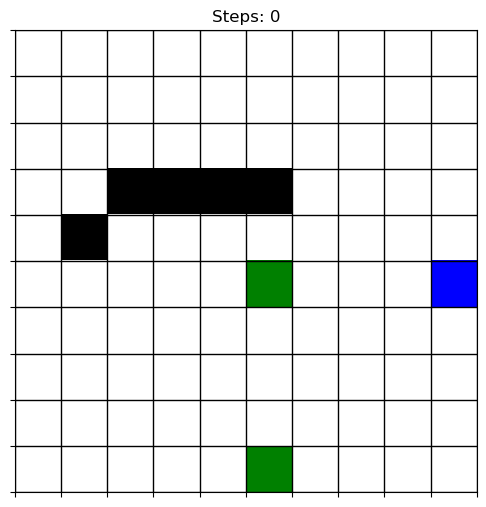

<Figure size 640x480 with 0 Axes>

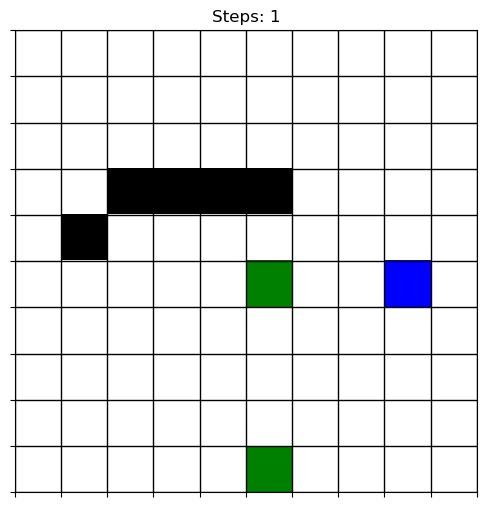

<Figure size 640x480 with 0 Axes>

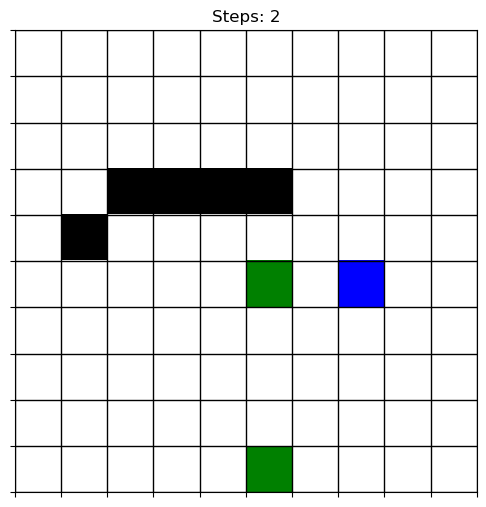

<Figure size 640x480 with 0 Axes>

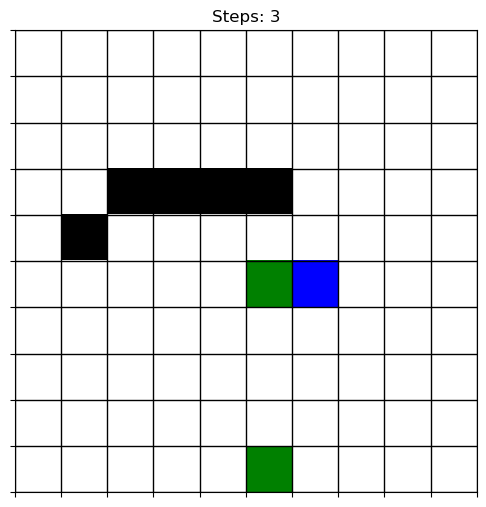

<Figure size 640x480 with 0 Axes>

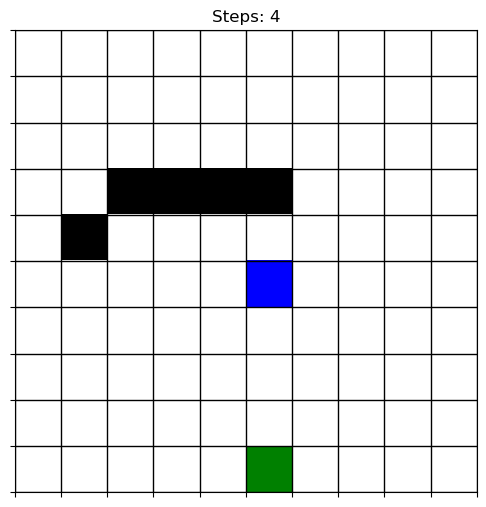

Goal reached in 4 steps!

Visualizing learned policy and Q-values...


<Figure size 640x480 with 0 Axes>

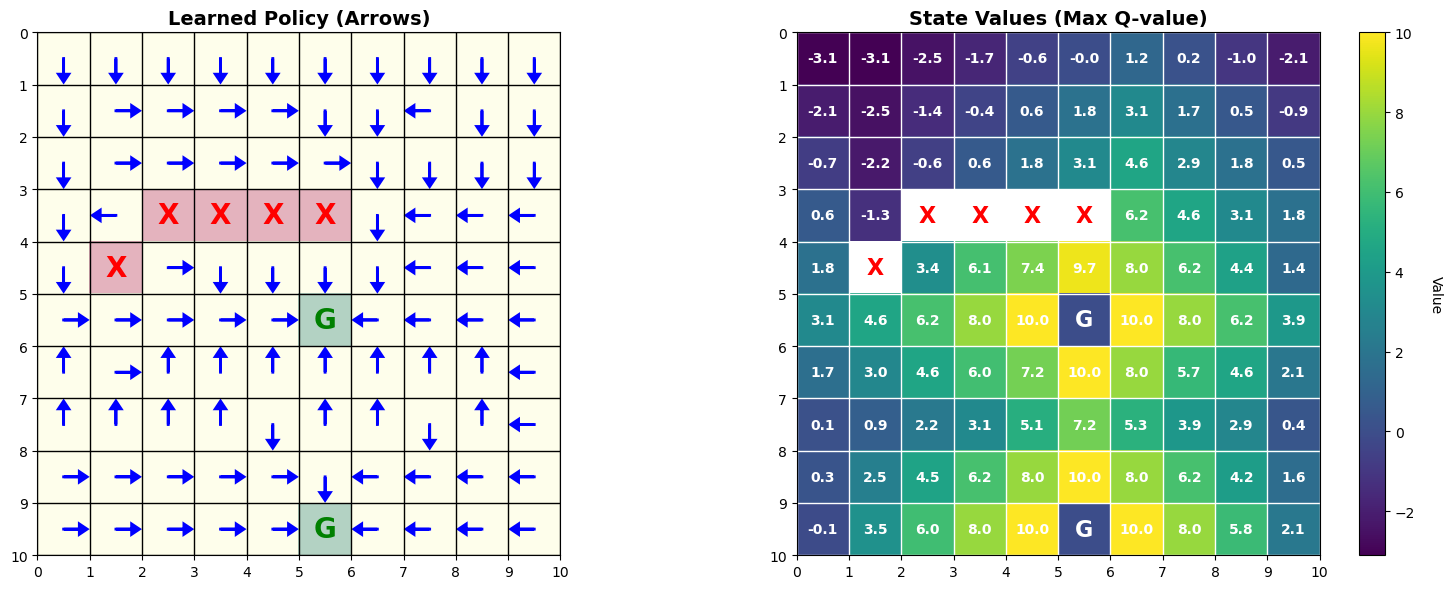

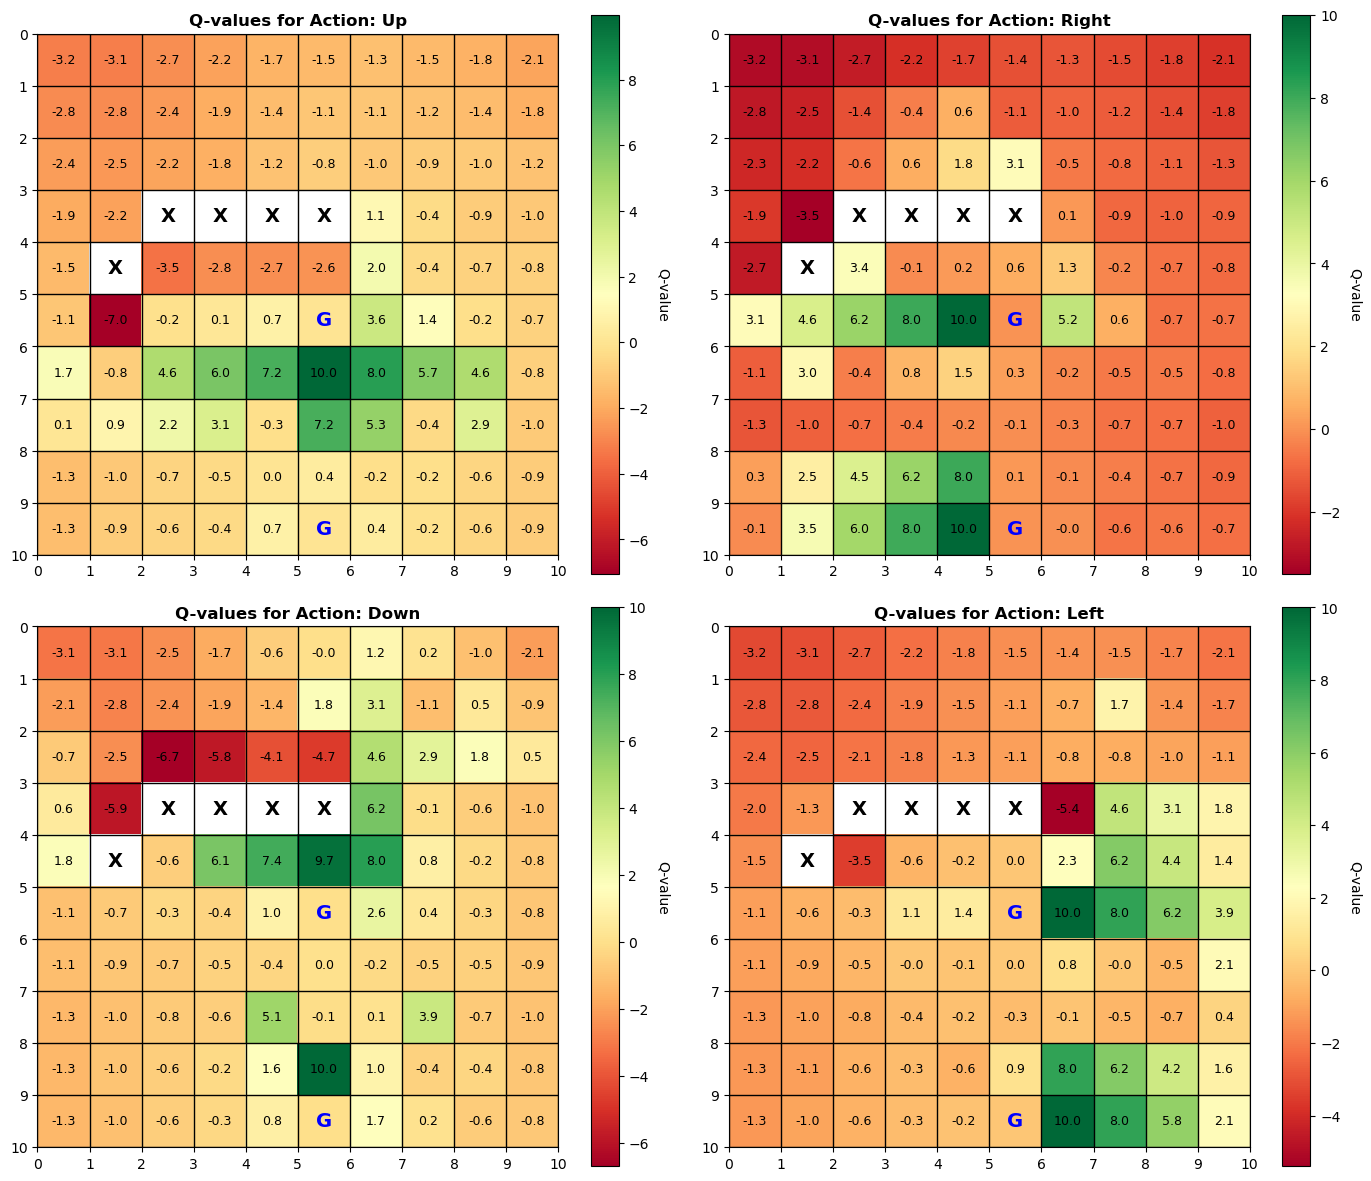

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

class Agent:
    def __init__(self):
        self.start = None
        self.pos = None
    
    def set_position(self, start):
        self.start = tuple(start)
    
    def reset(self):
        self.pos = tuple(self.start)
    
    def move(self, action, height, width):
        r, c = self.pos
        
        if action == 0:      # up
            r -= 1
        elif action == 1:    # right
            c += 1
        elif action == 2:    # down
            r += 1
        elif action == 3:    # left
            c -= 1
        
        # Check boundaries only
        if 0 <= r < height and 0 <= c < width:
            self.pos = (r, c)
        
        return self.pos


class GridWorld:
    def __init__(self, height=5, width=5, start=None, goal=None,
                 reward_goal=1, reward_step=-1, obstacles=None, obstacle_penalty=-100):
        self.height, self.width = height, width
        
        # Set obstacles
        self.obstacles = set(tuple(o) for o in obstacles) if obstacles else set()
        
        # Set start
        if start is not None:
            self.start = tuple(start)
        else:
            self.start = self._random_free_cell(exclude=[])
        
        # Set goals (support multiple)
        if goal is None:
            self.goals = [self._random_free_cell(exclude=[self.start] + list(self.obstacles))]
        elif isinstance(goal, list):
            self.goals = [tuple(g) for g in goal]
        else:
            self.goals = [tuple(goal)]
        
        # Check for conflicts
        assert self.start not in self.obstacles, "Start position can't be an obstacle"
        for g in self.goals:
            assert g not in self.obstacles, f"Goal {g} can't be an obstacle"
        
        # Agent
        self.agent = Agent()
        self.agent.set_position(self.start)
        
        # Rewards
        self.reward_goal = reward_goal
        self.reward_step = reward_step
        self.obstacle_penalty = obstacle_penalty
        self._steps = 0
        
        # Colormap: 0 empty, 2 agent, 3 goal, 4 obstacle
        self.cmap = colors.ListedColormap(["white", "blue", "green", "black"])
        self.norm = colors.BoundaryNorm([0, 2, 3, 4, 5], self.cmap.N)
    
    def _random_free_cell(self, exclude=[]):
        """Find a random cell not in exclude or obstacles."""
        exclude_set = set(exclude)
        while True:
            cell = (np.random.randint(0, self.height), np.random.randint(0, self.width))
            if cell not in exclude_set and cell not in self.obstacles:
                return cell
    def set_start_position(self, pos):
        """Set a new start position and update the agent."""
        assert pos not in self.obstacles, "Start position cannot be an obstacle"
        assert pos not in self.goals, "Start position cannot be a goal"
        self.start = pos
        self.agent.set_position(pos)

    def reset(self):
        self.agent.reset()
        self._steps = 0
        return self._get_obs()
    
    def step(self, action):
        self._steps += 1
        new_pos = self.agent.move(action, self.height, self.width)
        
        # Check rewards based on new position
        if new_pos in self.goals:
            reward = self.reward_goal
            done = True
        elif new_pos in self.obstacles:
            reward = self.obstacle_penalty
            done = False
        else:
            reward = self.reward_step
            done = False
        
        return self._get_obs(), reward, done
    
    def _get_obs(self):
        grid = np.zeros((self.height, self.width), dtype=np.int8)
        # mark obstacles
        for (orow, ocol) in self.obstacles:
            grid[orow, ocol] = 4
        # mark goals
        for (gr, gc) in self.goals:
            grid[gr, gc] = 3
        # mark agent
        ar, ac = self.agent.pos
        grid[ar, ac] = 2
        return grid
    
    def render(self, pause_time=3):
        grid = self._get_obs()
    
        plt.ion()  # Turn on interactive mode
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.clear()
        ax.imshow(grid, cmap=self.cmap, norm=self.norm, extent=[0, self.width, self.height, 0])
    
        # Grid lines
        ax.set_xticks(np.arange(0, self.width + 1, 1))
        ax.set_yticks(np.arange(0, self.height + 1, 1))
        ax.grid(color="black", linewidth=1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
        plt.title(f"Steps: {self._steps}")
        plt.draw()
        plt.pause(pause_time)
        plt.clf()  # Clear the figure for the next frame



class QLearningAgent:
    def __init__(self, env, gamma=0.9, alpha=0.1, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995):
        self.env = env
        self.gamma = gamma             # discount factor
        self.alpha = alpha             # learning rate
        self.epsilon = epsilon         # starting exploration probability
        self.epsilon_min = epsilon_min # minimum exploration probability
        self.epsilon_decay = epsilon_decay # decay rate
        
        # Q-table with shape (height, width, 4 actions)
        self.Q = np.zeros((env.height, env.width, 4))
    
    def choose_action(self, state):
        r, c = state
        if np.random.rand() < self.epsilon:
            return np.random.choice([0, 1, 2, 3])  # Explore
        else:
            return np.argmax(self.Q[r, c])         # Exploit
    
    def learn(self, num_episodes=5000, max_steps=200, random_start=False):
        for ep in range(num_episodes):
            # If random_start is True, select a new random start position
            if random_start:
                while True:
                    rand_pos = (np.random.randint(0, self.env.height),
                            np.random.randint(0, self.env.width))
                    if rand_pos not in self.env.obstacles and rand_pos not in self.env.goals:
                        break
                self.env.set_start_position(rand_pos)

            self.env.reset()
            state = self.env.agent.pos
            done = False
            steps = 0
        
            while not done and steps < max_steps:
                r, c = state
                action = self.choose_action(state)
                obs, reward, done = self.env.step(action)
                new_state = self.env.agent.pos
                nr, nc = new_state
            
                # Q-learning update rule
                best_next = np.max(self.Q[nr, nc])
                td_target = reward + self.gamma * best_next
                td_error = td_target - self.Q[r, c, action]
                self.Q[r, c, action] += self.alpha * td_error
            
                state = new_state
                steps += 1
        
            # Decay epsilon after each episode
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
                self.epsilon = max(self.epsilon_min, self.epsilon)
        
            # Optional: print progress
            if (ep + 1) % 500 == 0:
                print(f"Episode {ep + 1}/{num_episodes}, epsilon: {self.epsilon:.3f}")

    
    def act(self, state):
        r, c = state
        return np.argmax(self.Q[r, c])
    
    def plot_policy(self):
        """Visualize the learned policy with action values."""
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Policy arrows
        ax1 = axes[0]
        grid = np.zeros((self.env.height, self.env.width))
        
        # Mark obstacles and goals
        for obs in self.env.obstacles:
            grid[obs] = -1
        for goal in self.env.goals:
            grid[goal] = 1
        
        ax1.imshow(grid, cmap='RdYlGn', alpha=0.3, extent=[0, self.env.width, self.env.height, 0])
        ax1.set_xticks(np.arange(0, self.env.width + 1, 1))
        ax1.set_yticks(np.arange(0, self.env.height + 1, 1))
        ax1.grid(color="black", linewidth=1)
        ax1.set_title("Learned Policy (Arrows)", fontsize=14, fontweight='bold')
        
        # Arrow directions: 0=up, 1=right, 2=down, 3=left
        arrow_dx = [0, 0.3, 0, -0.3]
        arrow_dy = [-0.3, 0, 0.3, 0]
        
        for r in range(self.env.height):
            for c in range(self.env.width):
                if (r, c) not in self.env.obstacles and (r, c) not in self.env.goals:
                    best_action = np.argmax(self.Q[r, c])
                    ax1.arrow(c + 0.5, r + 0.5, arrow_dx[best_action], arrow_dy[best_action],
                             head_width=0.2, head_length=0.15, fc='blue', ec='blue', linewidth=2)
                elif (r, c) in self.env.obstacles:
                    ax1.text(c + 0.5, r + 0.5, 'X', ha='center', va='center', 
                            fontsize=20, fontweight='bold', color='red')
                elif (r, c) in self.env.goals:
                    ax1.text(c + 0.5, r + 0.5, 'G', ha='center', va='center', 
                            fontsize=20, fontweight='bold', color='green')
        
        # Plot 2: Value function (max Q-value per state)
        ax2 = axes[1]
        value_grid = np.max(self.Q, axis=2)
        
        # Set obstacles and goals to NaN for visualization
        for obs in self.env.obstacles:
            value_grid[obs] = np.nan
        
        im = ax2.imshow(value_grid, cmap='viridis', extent=[0, self.env.width, self.env.height, 0])
        ax2.set_xticks(np.arange(0, self.env.width + 1, 1))
        ax2.set_yticks(np.arange(0, self.env.height + 1, 1))
        ax2.grid(color="white", linewidth=1)
        ax2.set_title("State Values (Max Q-value)", fontsize=14, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax2)
        cbar.set_label('Value', rotation=270, labelpad=20)
        
        # Add text annotations with max Q-values
        for r in range(self.env.height):
            for c in range(self.env.width):
                if (r, c) in self.env.obstacles:
                    ax2.text(c + 0.5, r + 0.5, 'X', ha='center', va='center', 
                            fontsize=16, fontweight='bold', color='red')
                elif (r, c) in self.env.goals:
                    ax2.text(c + 0.5, r + 0.5, 'G', ha='center', va='center', 
                            fontsize=16, fontweight='bold', color='white')
                else:
                    max_val = np.max(self.Q[r, c])
                    ax2.text(c + 0.5, r + 0.5, f'{max_val:.1f}', ha='center', va='center', 
                            fontsize=10, color='white', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def plot_q_values_heatmap(self):
        """Plot Q-values for each action as separate heatmaps."""
        action_names = ['Up', 'Right', 'Down', 'Left']
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        axes = axes.flatten()
        
        for action_idx in range(4):
            ax = axes[action_idx]
            q_grid = self.Q[:, :, action_idx].copy()
            
            # Set obstacles to NaN
            for obs in self.env.obstacles:
                q_grid[obs] = np.nan
            
            im = ax.imshow(q_grid, cmap='RdYlGn', extent=[0, self.env.width, self.env.height, 0])
            ax.set_xticks(np.arange(0, self.env.width + 1, 1))
            ax.set_yticks(np.arange(0, self.env.height + 1, 1))
            ax.grid(color="black", linewidth=1)
            ax.set_title(f'Q-values for Action: {action_names[action_idx]}', fontsize=12, fontweight='bold')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('Q-value', rotation=270, labelpad=15)
            
            # Add text annotations
            for r in range(self.env.height):
                for c in range(self.env.width):
                    if (r, c) in self.env.obstacles:
                        ax.text(c + 0.5, r + 0.5, 'X', ha='center', va='center', 
                               fontsize=14, fontweight='bold', color='black')
                    elif (r, c) in self.env.goals:
                        ax.text(c + 0.5, r + 0.5, 'G', ha='center', va='center', 
                               fontsize=14, fontweight='bold', color='blue')
                    else:
                        q_val = self.Q[r, c, action_idx]
                        ax.text(c + 0.5, r + 0.5, f'{q_val:.1f}', ha='center', va='center', 
                               fontsize=9, color='black')
        
        plt.tight_layout()
        plt.show()


# Define environment parameters
height, width = 10, 10
start = None
goals = [(5, 5),(9,5)]
obstacles = [(3, 3), (3, 2), (3, 5), (4, 1), (3, 4)]

# Create environment
env = GridWorld(height=height, width=width, start=start, goal=goals, obstacles=obstacles,
                reward_goal=10, reward_step=-1, obstacle_penalty=-10)

# Create Q-learning agent
agent = QLearningAgent(env, gamma=0.9, alpha=0.1, epsilon=1.0,
                       epsilon_min=0.01, epsilon_decay=0.995)

# Train the agent
print("Training agent...")
agent.learn(num_episodes=2000, max_steps=20,random_start = True)
print("Training finished.")

# Test the learned policy (run one episode without exploration)
env.reset()
agent.epsilon = 0  # Turn off exploration for testing
done = False
steps = 0
print("\nTesting learned policy:")

while not done and steps < 50:
    env.render()
    action = agent.act(env.agent.pos)
    obs, reward, done = env.step(action)
    steps += 1

env.render()  # Show final state

if done:
    print(f"Goal reached in {steps} steps!")
else:
    print(f"Failed to reach goal in {steps} steps.")

# Visualize the learned policy
print("\nVisualizing learned policy and Q-values...")
agent.plot_policy()
agent.plot_q_values_heatmap()

WAAAY BETTER.

In [223]:
import time

def evaluate_grid_size(height, width, episodes=2000, test_runs=5, max_steps=50, eval_interval=10,random_start = False):
    print(f"\nEvaluating Grid Size: {height}x{width}")
    
    # Define obstacles and goals
    obstacles = [(r, c) for r in range(height//3, height//3+2)
                        for c in range(width//3, width//3+2)]
    
    goals = [(height-1, width-1)]
    
    env = GridWorld(height=height, width=width, start=(0,0), goal=goals,
                    obstacles=obstacles, reward_goal=10, reward_step=-1, obstacle_penalty=-10)
    
    agent = QLearningAgent(env, gamma=0.9, alpha=0.1, epsilon=1.0,
                           epsilon_min=0.01, epsilon_decay=0.995)
    
    convergence_history = []
    steps_to_goal_list = []
    eval_steps = []
    eval_points = []

    start_time = time.time()
    prev_Q = np.copy(agent.Q)

    for ep in range(episodes):
        agent.learn(num_episodes=100, max_steps=max_steps, random_start=random_start)
        
        # Track Q-delta convergence
        delta = np.sum(np.abs(agent.Q - prev_Q))
        convergence_history.append(delta)
        prev_Q = np.copy(agent.Q)
        
        # Evaluate steps to goal every eval_interval episodes
        if (ep + 1) % eval_interval == 0:
            agent_epsilon_backup = agent.epsilon
            agent.epsilon = 0  # Greedy policy for evaluation
            env.reset()
            steps = 0
            done = False
            while not done and steps < max_steps:
                action = agent.act(env.agent.pos)
                _, _, done = env.step(action)
                steps += 1
            eval_steps.append(steps if done else max_steps)
            eval_points.append(ep + 1)
            agent.epsilon = agent_epsilon_backup  # Restore epsilon

            print(f"  Episode {ep + 1}, Q-delta: {delta:.2f}, Eval Steps: {steps}")

    train_time = time.time() - start_time

    # Final test runs
    agent.epsilon = 0  # greedy
    for _ in range(test_runs):
        env.reset()
        steps = 0
        done = False
        while not done and steps < max_steps:
            action = agent.act(env.agent.pos)
            _, _, done = env.step(action)
            steps += 1
        steps_to_goal_list.append(steps if done else max_steps)
    
    return {
        "height": height,
        "width": width,
        "avg_steps": np.mean(steps_to_goal_list),
        "convergence": convergence_history,
        "train_time": train_time,
        "eval_steps": eval_steps,          # steps over training
        "eval_points": eval_points         # corresponding episode numbers
    }


In [210]:
grid_sizes = [(5,5), (10,10), (15,15), (20,20)]
results = []

for h, w in grid_sizes:
    result = evaluate_grid_size(h, w, episodes=250, max_steps=50,eval_interval = 10)
    results.append(result)



Evaluating Grid Size: 5x5
  Episode 10, Q-delta: 0.10, Eval Steps: 8
  Episode 20, Q-delta: 0.04, Eval Steps: 8
  Episode 30, Q-delta: 0.13, Eval Steps: 8
  Episode 40, Q-delta: 0.03, Eval Steps: 8
  Episode 50, Q-delta: 0.18, Eval Steps: 8
  Episode 60, Q-delta: 0.00, Eval Steps: 8
  Episode 70, Q-delta: 0.01, Eval Steps: 8
  Episode 80, Q-delta: 0.02, Eval Steps: 8
  Episode 90, Q-delta: 0.01, Eval Steps: 8
  Episode 100, Q-delta: 0.00, Eval Steps: 8
  Episode 110, Q-delta: 0.01, Eval Steps: 8
  Episode 120, Q-delta: 0.01, Eval Steps: 8
  Episode 130, Q-delta: 0.00, Eval Steps: 8
  Episode 140, Q-delta: 0.00, Eval Steps: 8
  Episode 150, Q-delta: 0.00, Eval Steps: 8
  Episode 160, Q-delta: 0.00, Eval Steps: 8
  Episode 170, Q-delta: 0.03, Eval Steps: 8
  Episode 180, Q-delta: 0.00, Eval Steps: 8
  Episode 190, Q-delta: 0.02, Eval Steps: 8
  Episode 200, Q-delta: 0.00, Eval Steps: 8
  Episode 210, Q-delta: 0.02, Eval Steps: 8
  Episode 220, Q-delta: 0.00, Eval Steps: 8
  Episode 230,

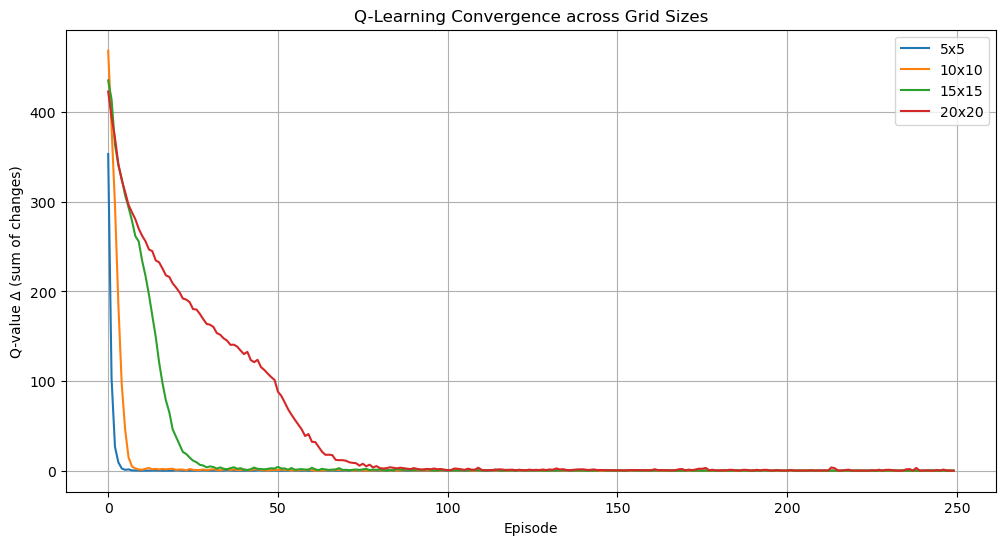

In [212]:
plt.figure(figsize=(12, 6))
for res in results:
    plt.plot(res["convergence"], label=f'{res["height"]}x{res["width"]}')
plt.xlabel("Episode")
plt.ylabel("Q-value Δ (sum of changes)")
plt.title("Q-Learning Convergence across Grid Sizes")
plt.legend()
plt.grid(True)
plt.show()


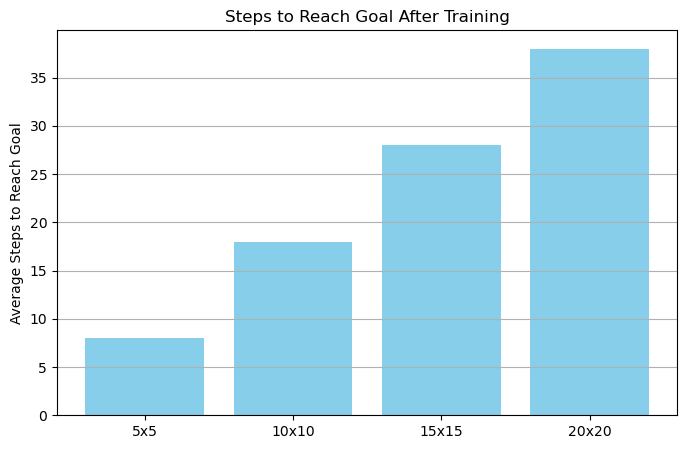

In [214]:
sizes = [f'{r["height"]}x{r["width"]}' for r in results]
avg_steps = [r["avg_steps"] for r in results]

plt.figure(figsize=(8, 5))
plt.bar(sizes, avg_steps, color='skyblue')
plt.ylabel("Average Steps to Reach Goal")
plt.title("Steps to Reach Goal After Training")
plt.grid(axis='y')
plt.show()


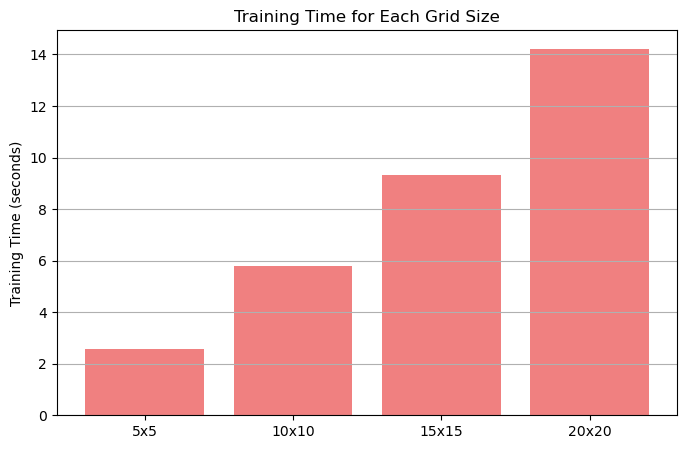

In [216]:
train_times = [r["train_time"] for r in results]

plt.figure(figsize=(8, 5))
plt.bar(sizes, train_times, color='lightcoral')
plt.ylabel("Training Time (seconds)")
plt.title("Training Time for Each Grid Size")
plt.grid(axis='y')
plt.show()


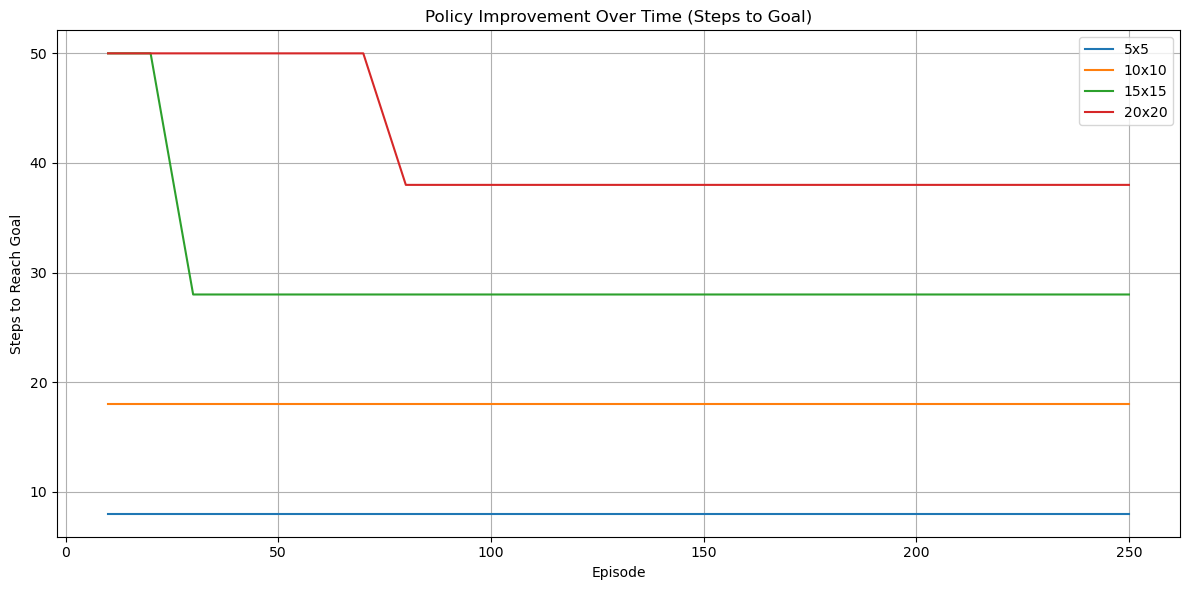

In [218]:
plt.figure(figsize=(12, 6))

for res in results:
    plt.plot(res["eval_points"], res["eval_steps"], label=f'{res["height"]}x{res["width"]}')

plt.xlabel("Episode")
plt.ylabel("Steps to Reach Goal")
plt.title("Policy Improvement Over Time (Steps to Goal)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


this was given same starting position, now we'll try using different starting position for better overall policy

In [237]:
results = []

for h, w in grid_sizes:
    result = evaluate_grid_size(h, w, episodes=250, max_steps=50,eval_interval = 10,random_start = True)
    results.append(result)


Evaluating Grid Size: 5x5
  Episode 10, Q-delta: 0.35, Eval Steps: 5
  Episode 20, Q-delta: 0.17, Eval Steps: 4
  Episode 30, Q-delta: 0.17, Eval Steps: 6
  Episode 40, Q-delta: 0.54, Eval Steps: 1
  Episode 50, Q-delta: 0.87, Eval Steps: 3
  Episode 60, Q-delta: 0.63, Eval Steps: 3
  Episode 70, Q-delta: 0.20, Eval Steps: 7
  Episode 80, Q-delta: 0.45, Eval Steps: 8
  Episode 90, Q-delta: 0.29, Eval Steps: 7
  Episode 100, Q-delta: 0.30, Eval Steps: 4
  Episode 110, Q-delta: 0.16, Eval Steps: 4
  Episode 120, Q-delta: 0.34, Eval Steps: 5
  Episode 130, Q-delta: 0.54, Eval Steps: 3
  Episode 140, Q-delta: 0.15, Eval Steps: 2
  Episode 150, Q-delta: 0.12, Eval Steps: 6
  Episode 160, Q-delta: 0.16, Eval Steps: 2
  Episode 170, Q-delta: 0.23, Eval Steps: 6
  Episode 180, Q-delta: 0.05, Eval Steps: 4
  Episode 190, Q-delta: 0.24, Eval Steps: 3
  Episode 200, Q-delta: 0.01, Eval Steps: 4
  Episode 210, Q-delta: 0.03, Eval Steps: 2
  Episode 220, Q-delta: 0.25, Eval Steps: 6
  Episode 230,

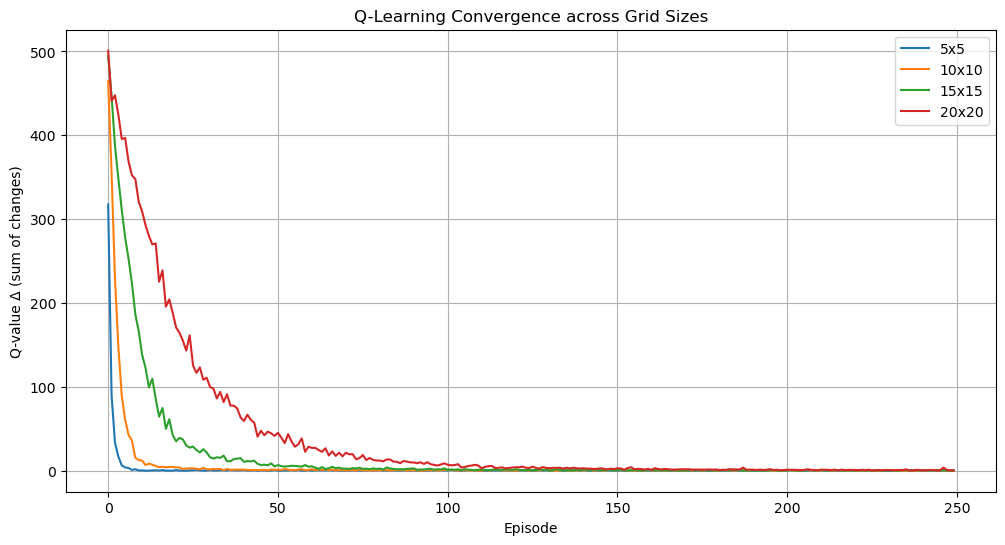

In [239]:
plt.figure(figsize=(12, 6))
for res in results:
    plt.plot(res["convergence"], label=f'{res["height"]}x{res["width"]}')
plt.xlabel("Episode")
plt.ylabel("Q-value Δ (sum of changes)")
plt.title("Q-Learning Convergence across Grid Sizes")
plt.legend()
plt.grid(True)
plt.show()


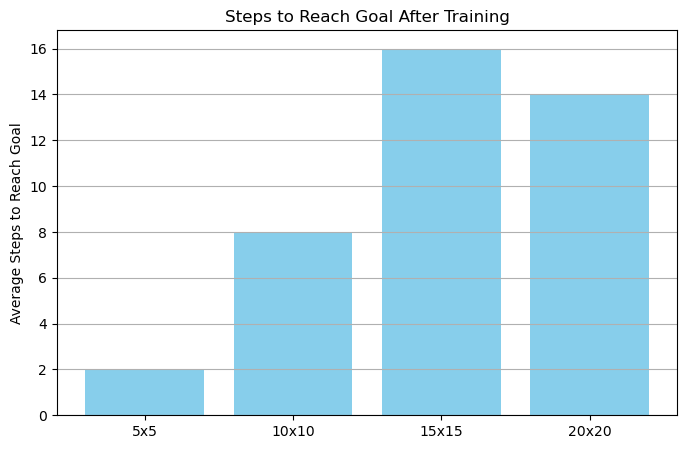

In [241]:
sizes = [f'{r["height"]}x{r["width"]}' for r in results]
avg_steps = [r["avg_steps"] for r in results]

plt.figure(figsize=(8, 5))
plt.bar(sizes, avg_steps, color='skyblue')
plt.ylabel("Average Steps to Reach Goal")
plt.title("Steps to Reach Goal After Training")
plt.grid(axis='y')
plt.show()


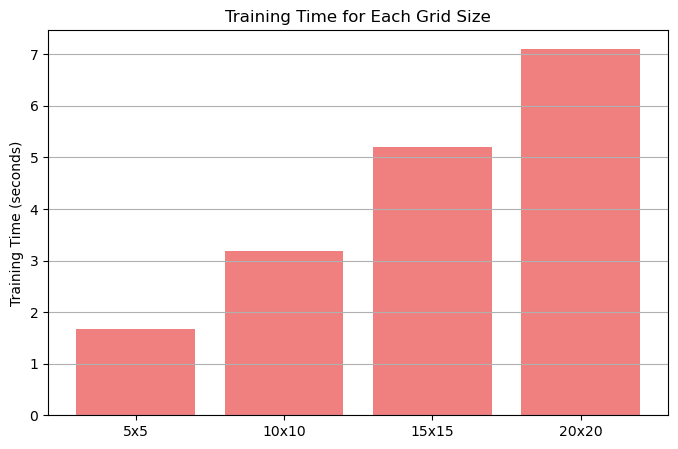

In [243]:
train_times = [r["train_time"] for r in results]

plt.figure(figsize=(8, 5))
plt.bar(sizes, train_times, color='lightcoral')
plt.ylabel("Training Time (seconds)")
plt.title("Training Time for Each Grid Size")
plt.grid(axis='y')
plt.show()


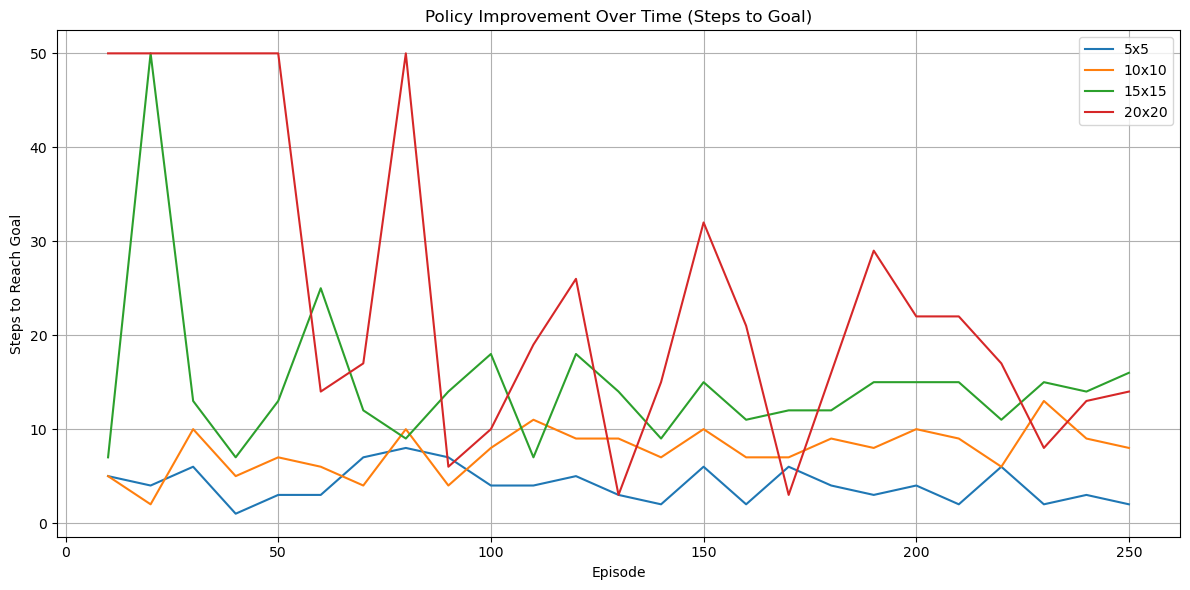

In [245]:
plt.figure(figsize=(12, 6))

for res in results:
    plt.plot(res["eval_points"], res["eval_steps"], label=f'{res["height"]}x{res["width"]}')

plt.xlabel("Episode")
plt.ylabel("Steps to Reach Goal")
plt.title("Policy Improvement Over Time (Steps to Goal)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#now 